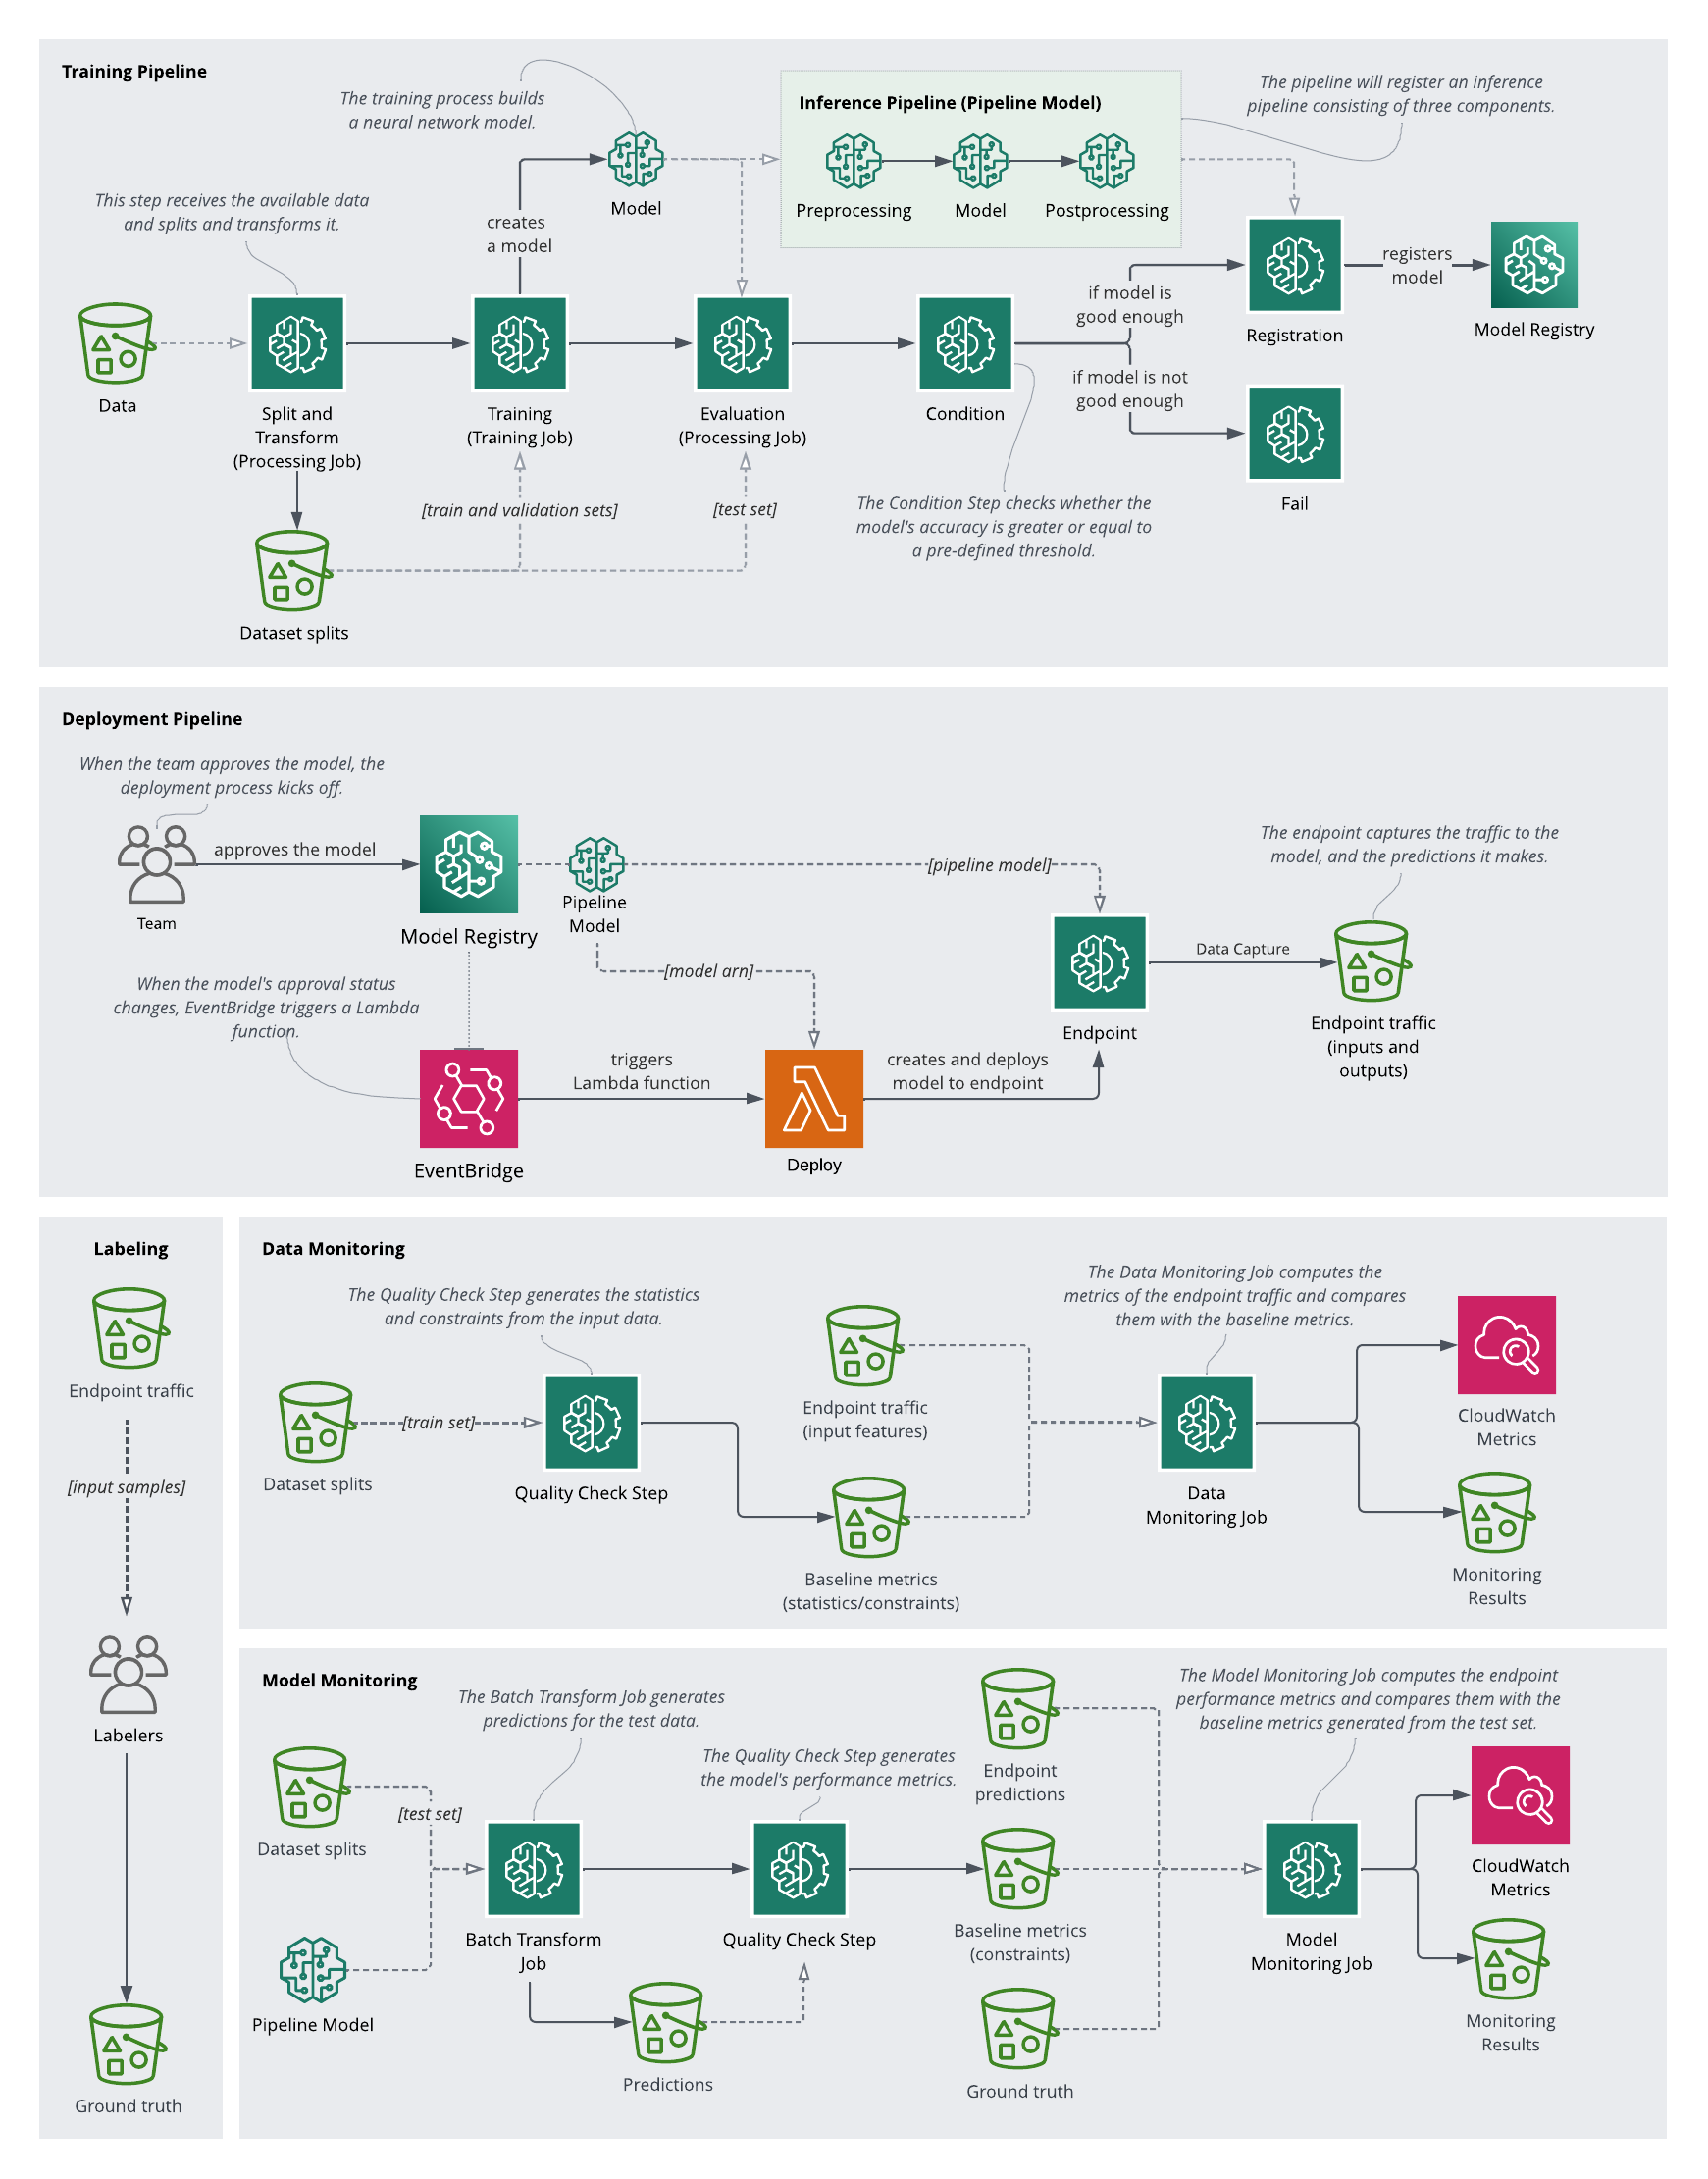

 The Architecture basically consists of 4 pipeline -  A training pipeline, an inference pipeline, a deployment pipeline, and a monitoring pipeline.

Above is an architectural diagram showing how the system is structured:

Lets set up the environment and prepare to run the notebook.

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import os
import json
import logging
import sys
from pathlib import Path

import ipytest

CODE_FOLDER = Path("code")

if not os.path.exists(CODE_FOLDER):
    os.makedirs(CODE_FOLDER)
    
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "penguins.csv"

ipytest.autoconfig(raise_on_error=True)

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


We can run this notebook in Local Mode to test some of the system components in local environment. Unfortunately, not every component is supported in Local Mode.

Setting the LOCAL_MODE variable to True will run every supported pipeline component locally. Setting the variable to False will run the pipeline in SageMaker.

In [10]:
LOCAL_MODE = True

Loading the environment variables we need to run the notebook.

In [11]:
import os

bucket = os.environ["BUCKET"]
role = os.environ["ROLE"]

COMET_API_KEY = os.environ.get("COMET_API_KEY", None)
COMET_PROJECT_NAME = os.environ.get("COMET_PROJECT_NAME", None)

In [15]:
# We can retrieve the architecture of the local
# computer using the `uname -m` command.
architecture = !(uname -m)

IS_ARM64_ARCHITECTURE = architecture[0] == "arm64"

Let's create a configuration dictionary with different settings depending on whether we are running the pipeline in Local Mode. We'll use this dictionary to configure the pipeline components.

In [13]:
import sagemaker
from sagemaker.workflow.pipeline_context import LocalPipelineSession, PipelineSession

pipeline_session = PipelineSession(default_bucket=bucket) if not LOCAL_MODE else None

if LOCAL_MODE:
    config = {
        "session": LocalPipelineSession(default_bucket=bucket),
        "instance_type": "local",
        # We need to use a custom Docker image when we run the pipeline
        # in Local Model on an ARM64 machine.
        "image": (
            "sagemaker-tensorflow-toolkit-local" if IS_ARM64_ARCHITECTURE else None
        ),
    }
else:
    config = {
        "session": pipeline_session,
        "instance_type": "ml.m5.xlarge",
        "image": None,
    }

# These specific settings refer to the SageMaker
# TensorFlow container we'll use.
config["framework_version"] = "2.12"
config["py_version"] = "py310"

Windows Support for Local Mode is Experimental


In [14]:
import boto3

S3_LOCATION = f"s3://{bucket}/penguins"

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

# Exploratory Data Analysis

In [16]:
import numpy as np
import pandas as pd

penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


We can see the dataset contains the following columns:

species: The species of a penguin. This is the column we want to predict.

island: The island where the penguin was found

culmen_length_mm: The length of the penguin's culmen (bill) in millimeters

culmen_depth_mm: The depth of the penguin's culmen in millimeters

flipper_length_mm: The length of the penguin's flipper in millimeters

body_mass_g: The body mass of the penguin in grams

sex: The sex of the penguin

In [17]:
penguins.describe(include="all")

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


In [18]:
species_distribution = penguins["species"].value_counts()
island_distribution = penguins["island"].value_counts()
sex_distribution = penguins["sex"].value_counts()

print(species_distribution, end="\n\n")
print(island_distribution, end="\n\n")
print(sex_distribution)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64


The distribution of the categories in our data are:

1. species: There are 3 species of penguins in the dataset: Adelie (152), Gentoo (124), and Chinstrap (68).
2. island: Penguins are from 3 islands: Biscoe (168), Dream (124), and Torgersen (52).
3. sex: We have 168 male penguins, 165 female penguins, and 1 penguin with an ambiguous gender (.).

Let's replace the ambiguous value in the sex column with a null value:

In [19]:
penguins["sex"] = penguins["sex"].replace(".", np.nan)

# Let's display the new distribution of the column:
sex_distribution = penguins["sex"].value_counts()
sex_distribution

sex
MALE      168
FEMALE    165
Name: count, dtype: int64

In [20]:
penguins.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Let get rid of the missing values.

In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:, :] = imputer.fit_transform(penguins)

# Let's display again the number of missing values:
penguins.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

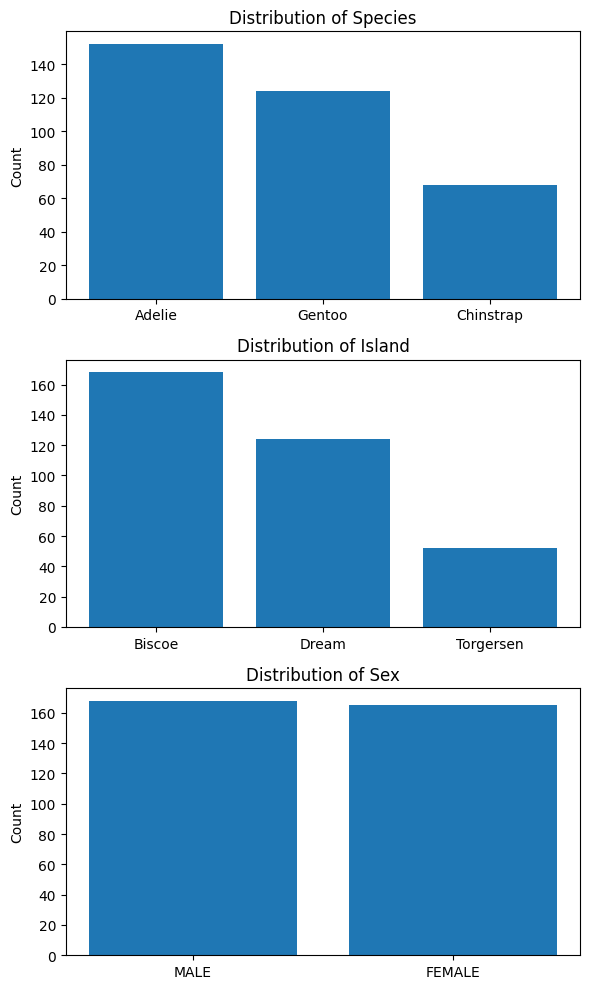

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].bar(species_distribution.index, species_distribution.values)
axs[0].set_ylabel("Count")
axs[0].set_title("Distribution of Species")

axs[1].bar(island_distribution.index, island_distribution.values)
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of Island")

axs[2].bar(sex_distribution.index, sex_distribution.values)
axs[2].set_ylabel("Count")
axs[2].set_title("Distribution of Sex")

plt.tight_layout()
plt.show()

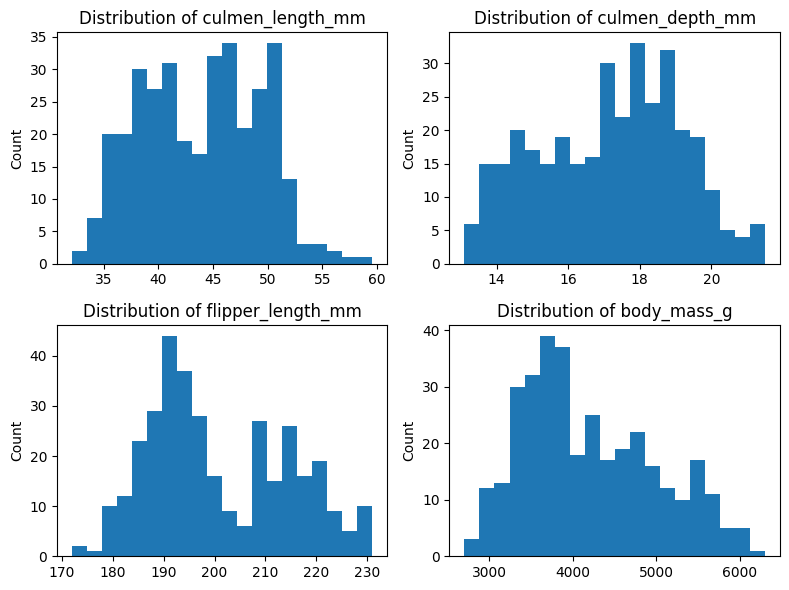

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].hist(penguins["culmen_length_mm"], bins=20)
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Distribution of culmen_length_mm")

axs[0, 1].hist(penguins["culmen_depth_mm"], bins=20)
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_title("Distribution of culmen_depth_mm")

axs[1, 0].hist(penguins["flipper_length_mm"], bins=20)
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Distribution of flipper_length_mm")

axs[1, 1].hist(penguins["body_mass_g"], bins=20)
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Distribution of body_mass_g")

plt.tight_layout()
plt.show()

In [24]:
penguins.cov(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,29.679415,-2.516984,50.260588,2596.971151
culmen_depth_mm,-2.516984,3.877201,-16.108849,-742.660180
flipper_length_mm,50.260588,-16.108849,197.269501,9792.552037
body_mass_g,2596.971151,-742.660180,9792.552037,640316.716388


Here are three examples of what we get from interpreting the covariance matrix below:

1. The positive covariance of 50.26 between culmen length and flippler length suggests that larger values of culmen length are associated with larger values of flipper length. As one increases, generally so does the other.
2. The positive covariance of 2596.97 between culmen length and body mass suggests that heavier penguins generally have longer culmens. There is a tendency for these two variables to increase together.
3. The negative covariance of -742.66 between culmen depth and body mass suggests a general tendency that penguins with deeper culmens weigh less.

Let's now display the correlation matrix. "Correlation" measures both the strength and direction of the linear relationship between two variables:

In [25]:
penguins.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.234635,0.656856,0.595720
culmen_depth_mm,-0.234635,1.000000,-0.582472,-0.471339
flipper_length_mm,0.656856,-0.582472,1.000000,0.871302
body_mass_g,0.595720,-0.471339,0.871302,1.000000


Here are three examples of what we get from interpreting the correlation matrix below:

1. Penguins that weight more tend to have longer flippers.
2. Penguins with a shallower culmen tend to have longer flippers.
3. Penguins with longer culmens tend to have longer flippers.

Let's display the distribution of species by island:

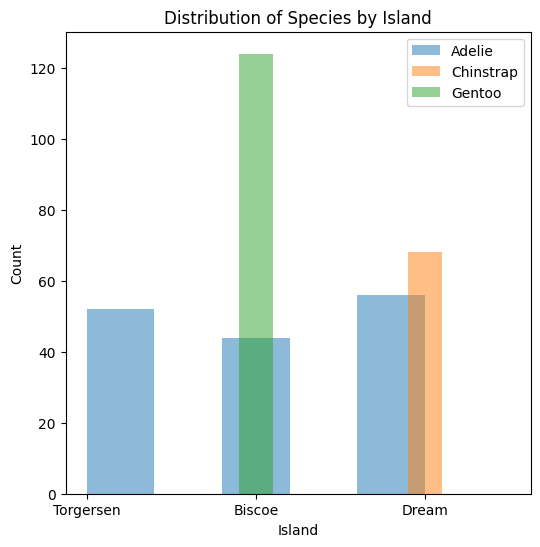

In [26]:
unique_species = penguins["species"].unique()

fig, ax = plt.subplots(figsize=(6, 6))
for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["island"], bins=5, alpha=0.5, label=species)

ax.set_xlabel("Island")
ax.set_ylabel("Count")
ax.set_title("Distribution of Species by Island")
ax.legend()
plt.show()


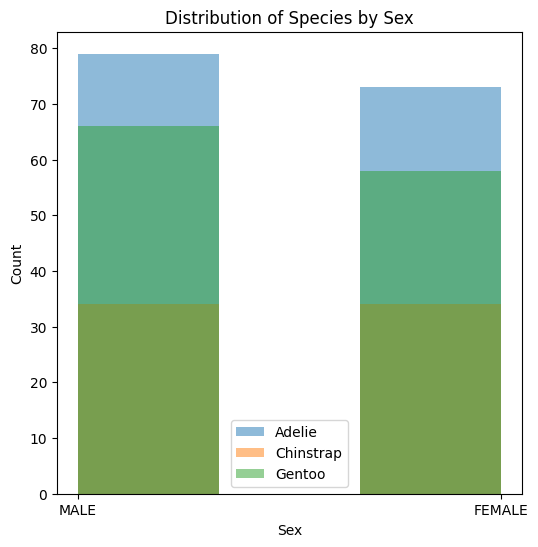

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))

for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["sex"], bins=3, alpha=0.5, label=species)

ax.set_xlabel("Sex")
ax.set_ylabel("Count")
ax.set_title("Distribution of Species by Sex")

ax.legend()
plt.show()